# A MINIMUM NOTE BOOK FOR 3D CNN

### 1. Install this packages for correctly reading images (credit : [this notebook of @samuelcortinhas](https://www.kaggle.com/code/samuelcortinhas/rsna-fracture-detection-in-depth-eda))
## BUT BEFORE YOU HAVE TO ADD pydicom utility : Add Data menu --> search for Pydicom Utility --> add the data

In [1]:
!pip install -qU '../input/for-pydicom/python_gdcm-3.0.14-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl' --find-links frozen_packages --no-index


In [2]:
!pip install -qU '../input/for-pydicom/pylibjpeg-1.4.0-py3-none-any.whl' --find-links frozen_packages --no-index

In [3]:
!head ../input/rsna*/train.csv



StudyInstanceUID,patient_overall,C1,C2,C3,C4,C5,C6,C7
1.2.826.0.1.3680043.6200,1,1,1,0,0,0,0,0
1.2.826.0.1.3680043.27262,1,0,1,0,0,0,0,0
1.2.826.0.1.3680043.21561,1,0,1,0,0,0,0,0
1.2.826.0.1.3680043.12351,0,0,0,0,0,0,0,0
1.2.826.0.1.3680043.1363,1,0,0,0,0,1,0,0
1.2.826.0.1.3680043.4859,1,0,0,0,0,0,1,0
1.2.826.0.1.3680043.18659,1,0,0,0,1,0,0,1
1.2.826.0.1.3680043.17364,0,0,0,0,0,0,0,0
1.2.826.0.1.3680043.849,0,0,0,0,0,0,0,0


### 2. Import the necessary packages

In [4]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
sns.set(style='darkgrid', font_scale=1.6)
import cv2
from os import listdir
import re
import gc
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut
from tqdm import tqdm
import nibabel as nib
import random

### 3. Explore the csv files : train.csv and train_bounding_boxes

#### Read train.csv

In [5]:
train = pd.read_csv('../input/rsna-2022-cervical-spine-fracture-detection/train.csv')
print(train.info())
train.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2019 entries, 0 to 2018
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   StudyInstanceUID  2019 non-null   object
 1   patient_overall   2019 non-null   int64 
 2   C1                2019 non-null   int64 
 3   C2                2019 non-null   int64 
 4   C3                2019 non-null   int64 
 5   C4                2019 non-null   int64 
 6   C5                2019 non-null   int64 
 7   C6                2019 non-null   int64 
 8   C7                2019 non-null   int64 
dtypes: int64(8), object(1)
memory usage: 142.1+ KB
None


,StudyInstanceUID,patient_overall,C1,C2,C3,C4,C5,C6,C7
0,1.2.826.0.1.3680043.6200,1,1,1,0,0,0,0,0
1,1.2.826.0.1.3680043.27262,1,0,1,0,0,0,0,0
2,1.2.826.0.1.3680043.21561,1,0,1,0,0,0,0,0
3,1.2.826.0.1.3680043.12351,0,0,0,0,0,0,0,0
4,1.2.826.0.1.3680043.1363,1,0,0,0,0,1,0,0
5,1.2.826.0.1.3680043.4859,1,0,0,0,0,0,1,0
6,1.2.826.0.1.3680043.18659,1,0,0,0,1,0,0,1
7,1.2.826.0.1.3680043.17364,0,0,0,0,0,0,0,0
8,1.2.826.0.1.3680043.849,0,0,0,0,0,0,0,0
9,1.2.826.0.1.3680043.24045,1,0,0,0,0,0,0,1


#### Let's create a function that returns a list of the fractured bones of a given id. We may need it later

In [6]:
def get_fractured_bones(patient_id):
    fractured_bones = []
    temp = train.loc[train.StudyInstanceUID == patient_id,['C1','C2', 'C3', 'C4', 'C5', 'C6', 'C7']]
    temp = list(temp.values[0]) # there is one row per id
    for i in range(len(temp)):
        if temp[i] == 1:
            fractured_bones.append('C' + str(i+1))
    return fractured_bones

In [7]:
# Test the function
get_fractured_bones('1.2.826.0.1.3680043.6200')



['C1', 'C2']

In [8]:
# path of train images
path_ti = '/kaggle/input/rsna-2022-cervical-spine-fracture-detection/train_images'


In [9]:
cols = ['patient_overall', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7'] # for labels

# The 3D CNN Model (a simple one !)

In [10]:
# import libraries
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop
import tensorflow as tf
from tensorflow import keras

In [11]:
#gpu related
#os.environ['TFF_CPP_MIN_LOG_LEVEL']='2'
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True) 

2022-09-27 04:07:06.618820: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-27 04:07:06.725297: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-27 04:07:06.726285: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


# Loss function for competition.


In [12]:
def CustomMSE(y_true, y_pred):
    neg = tf.constant([[1, 1, 1, 1, 1, 1, 1, 7]],dtype=tf.float32)
    pos = neg*2
    eps=1E-8 
    
    #y_true=tf.cast(y_true,tf.float32)
    #y_pred=tf.cast( y_pred,tf.float32)
    
    y_pred=tf.math.maximum(eps,tf.math.minimum(1-eps, y_pred))
    
   
    
    L=tf.cast(y_true,tf.float32)*tf.math.log( y_pred)+(1.0-tf.cast(y_true,tf.float32))*tf.math.log(1- y_pred)
        
        #print(y_true.shape)
        #pos=tf.broadcast_to(pos,y_true)
        #neg=tf.broadcast_to(neg,y_true)
        
    w=pos*tf.cast(y_true,tf.float32)+neg*(1-tf.cast(y_true,tf.float32))
        #print(tf.reduce_sum(L*w,1))
        #print(tf.reduce_sum(w,1))
    return -( tf.reduce_sum(L*w,1)/tf.reduce_sum(w,1) ) 


https://www.kaggle.com/code/vslaykovsky/train-pytorch-effnetv2-baseline-cv-0-49/notebook

loss tensor([[2.3026, 0.1054, 0.1054, 0.1054, 0.1054, 0.1054, 0.1054, 0.1054],
        [0.1054, 2.3026, 0.1054, 0.1054, 0.1054, 0.1054, 0.1054, 0.1054]],
       device='cuda:0')
       
all weights tensor([[14.,  2.,  1.,  1.,  1.,  1.,  1.,  1.],
        [ 7.,  1.,  1.,  1.,  1.,  1.,  1.,  1.]], device='cuda:0')
        
weighted loss tensor([[32.2362,  0.2107,  0.1054,  0.1054,  0.1054,  0.1054,  0.1054,  0.1054],
        [ 0.7375,  2.3026,  0.1054,  0.1054,  0.1054,  0.1054,  0.1054,  0.1054]],
       device='cuda:0')
       
normalization factors tensor([[22.],
        [14.]], device='cuda:0')
        
normalized loss tensor([[1.4653, 0.0096, 0.0048, 0.0048, 0.0048, 0.0048, 0.0048, 0.0048],
        [0.0527, 0.1645, 0.0075, 0.0075, 0.0075, 0.0075, 0.0075, 0.0075]],
       device='cuda:0')
       
summed up over patient_overall-C1-C7 loss tensor([1.5036, 0.2623], device='cuda:0')

In [13]:
y_test1=[[ 0.9, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,0.1],
        [0.9, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,0.1] ]
 
y_true1=[
        [1., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0, 0., 0., 0., 0., 0., 0.]
    ]
CustomMSE(y_true1,y_test1)

2022-09-27 04:07:06.853124: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-27 04:07:06.853710: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-27 04:07:06.854753: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-27 04:07:06.855486: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([1.5035943, 0.2623051], dtype=float32)>

Our CustomMSE delivers competition metric! 

In [14]:
def get_cut(id_files, num=32):  #get appropriate 32 2D cuts for single patient
    x = []
    x_32 = []
    
    for nam in id_files:
        x.append(int(nam.split('.')[0]))
    x.sort()
    x_len=len(x)
    
    # get 32 cut out of all cuts
    for i in range(32):
        x_32.append(x[ min(x_len-1,i*min(x_len/32,1))])
    
    return x_32

In [15]:
def norm(image):
    s = np.std(image)
    m = np.mean(image)
     
    return s,m

In [16]:
def get_train_images_3D(train_df, n_ids = 10, n_img = 10, img_size = (64,64)):
    
    train_images = []
    train_labels = []
    
    # get n_ids ids at random
    ids = random.sample(list(train_df['StudyInstanceUID'].values), n_ids)
    
    
    for id_ in ids:
        # get labels for tha id_
        labels = train_df.loc[train_df['StudyInstanceUID'] == id_, cols].values[0]
        # label C1-C7 fracture or not, print(labels)
        # file names of that id_
        id_files = os.listdir(path_ti + '/' + id_) 
        cas = []  # a 3D tensor for a patient scan
        cuts = get_cut(id_files,32)  # index of 32 cuts
        
        # read each of the dcm files
        for i in range(32):
            try:
                image = pydicom.dcmread(path_ti + '/' + id_ + '/' + str(cuts[i])+'.dcm').pixel_array
            except:
                print('error')
            # resize image
            image = np.array(cv2.resize(image, dsize=img_size))
            # rescale image
            s, m=norm(image)
            image = (image - m)/s 
            # add image to train_image
            cas.append(image)
           # print(np.array(cas).shape)
            # add labels train_labels
        train_images.append(cas)   
        train_labels.append(labels)
    return train_images, train_labels
a=get_train_images_3D(train,6,6)
(tf.convert_to_tensor(a[0],dtype=tf.float32)).shape

TensorShape([6, 32, 64, 64])

In [17]:
#tmp= get_train_images_3D(train,200,200) 
#X=tf.convert_to_tensor(tmp[0], dtype=tf.float32)
#Y=tf.convert_to_tensor(tmp[1], dtype=tf.float32)
from sklearn.model_selection import train_test_split
X,Y = get_train_images_3D(train,360,360,(128,128))

In [18]:
tmp2 = train_test_split(X, Y,test_size=.001)#train_X, val_X, train_Y, val_Y = train_test_split(X, Y)

train3D_X = (tf.convert_to_tensor(tmp2[0],dtype=tf.float32))
val3D_X = (tf.convert_to_tensor(tmp2[1],dtype=tf.float32))

train3D_Y = (tf.convert_to_tensor(tmp2[2],dtype=tf.float32))
val3D_Y = (tf.convert_to_tensor(tmp2[3],dtype=tf.float32))
#print(train_X.shape, train_Y.shape, val_X.shape, val_Y.shape)

In [19]:
def get_model_3D(img_size=64):
    
    img_input = layers.Input(shape=(32,img_size,img_size,1))

    # First convolution extracts 16 filters that are 3x3
    # Convolution is followed by max-pooling layer with a 2x2 window
    x = layers.Conv3D(32, 3, activation='relu')(img_input)
   # x = layers.MaxPooling3D(2)(x)
   
    xt = layers.Conv3D(24, 3, activation='relu')(x)
    
    x2 = layers.Conv3D(16, 3, activation='relu')(xt)
   # x2 = layers.MaxPooling3D(2)(x2)
    
    x3 = layers.Conv3D(8, 3, activation='relu')(x2)
    x3 = layers.MaxPooling3D(2)(x3)
    # Flatten feature map to a 1-dim tensor so we can add fully connected layers
    x3 = layers.Flatten()(x3)

    # Create output layer with a single node and sigmoid activation
    output = layers.Dense(8, activation='sigmoid')(x3)


    # Create model:
    model = Model(img_input, output)
    
    return model

In [20]:
def model_3D_getfit(A,B,img_size):
    tf.keras.backend.clear_session()
    model = get_model_3D(img_size)
    model.summary()
    model.compile( loss=CustomMSE , #competition_loss,
                # loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=RMSprop(learning_rate=0.00001),
              metrics=['acc'])


    history = model.fit(A,B, validation_split=0.1, epochs =11) #delete
    return model, history

In [21]:
model_3D, history_3D = model_3D_getfit(train3D_X,train3D_Y,128)
print("loss for validation data = ")
val3D_prediction=model_3D.predict(val3D_X)
val_3D_loss = tf.reduce_mean(CustomMSE(val3D_Y,val3D_prediction),keepdims=False)
print(val_3D_loss)



Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 128, 128, 1)] 0         
_________________________________________________________________
conv3d (Conv3D)              (None, 30, 126, 126, 32)  896       
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 28, 124, 124, 24)  20760     
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 26, 122, 122, 16)  10384     
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 24, 120, 120, 8)   3464      
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 12, 60, 60, 8)     0         
_________________________________________________________________
flatten (Flatten)            (None, 345600)            0     

2022-09-27 04:10:24.688992: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/11


2022-09-27 04:10:26.586229: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


11/11 [==============================] - 31s 2s/step - loss: 0.5346 - acc: 0.9102 - val_loss: 0.5101 - val_acc: 1.0000
Epoch 2/11
11/11 [==============================] - 15s 1s/step - loss: 0.5020 - acc: 1.0000 - val_loss: 0.4982 - val_acc: 1.0000
Epoch 3/11
11/11 [==============================] - 15s 1s/step - loss: 0.4942 - acc: 1.0000 - val_loss: 0.4917 - val_acc: 1.0000
Epoch 4/11
11/11 [==============================] - 15s 1s/step - loss: 0.4863 - acc: 1.0000 - val_loss: 0.5134 - val_acc: 1.0000
Epoch 5/11
11/11 [==============================] - 15s 1s/step - loss: 0.4882 - acc: 1.0000 - val_loss: 0.5011 - val_acc: 1.0000
Epoch 6/11
11/11 [==============================] - 15s 1s/step - loss: 0.4838 - acc: 1.0000 - val_loss: 0.4922 - val_acc: 1.0000
Epoch 7/11
11/11 [==============================] - 15s 1s/step - loss: 0.4730 - acc: 1.0000 - val_loss: 0.5137 - val_acc: 1.0000
Epoch 8/11
11/11 [==============================] - 15s 1s/step - loss: 0.4718 - acc: 1.0000 - val_lo

In [22]:
'''
def cheat(val3D_prediction):
    tmpv=val3D_prediction
    n=val3D_prediction.shape[0]
    print(tmpv[0])
    for i in range(n):
        for j in range(7):
            tmpv[i][7]=max(tmpv[i][j],tmpv[i][7])
        #=max(0,1-tmpv[i][0])*max(0,1-tmpv[i][1])*max(0,1-tmpv[i][2])*max(0,1-tmpv[i][3])*max(0,1-tmpv[i][4])*max(0,1-tmpv[i][5])*max(0,1-tmpv[i][6])
    return tmpv
val_3D_loss = tf.reduce_mean(CustomMSE(val3D_Y,cheat(val3D_prediction)),keepdims=False)
print(val_3D_loss)
'''

'\ndef cheat(val3D_prediction):\n    tmpv=val3D_prediction\n    n=val3D_prediction.shape[0]\n    print(tmpv[0])\n    for i in range(n):\n        for j in range(7):\n            tmpv[i][7]=max(tmpv[i][j],tmpv[i][7])\n        #=max(0,1-tmpv[i][0])*max(0,1-tmpv[i][1])*max(0,1-tmpv[i][2])*max(0,1-tmpv[i][3])*max(0,1-tmpv[i][4])*max(0,1-tmpv[i][5])*max(0,1-tmpv[i][6])\n    return tmpv\nval_3D_loss = tf.reduce_mean(CustomMSE(val3D_Y,cheat(val3D_prediction)),keepdims=False)\nprint(val_3D_loss)\n'

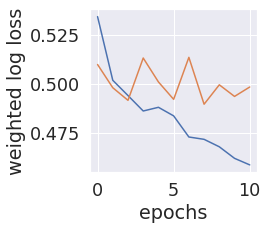

In [23]:
#Define figure and axes
fig, ax = plt.subplots(1,1, figsize=(3,3))
#ax.set_ylim(ymin=0)
plt.xlabel("epochs")
plt.ylabel("weighted log loss")

# add the image
#print(history_3D.history )
plt.plot(history_3D.history['loss'])

plt.plot(history_3D.history['val_loss'])
#plt.scatter(len(history_3D.history['val_loss']),val_3D_loss)
#plt.scatter(10,history_3D.history['loss'][0])
# Add the boxe
#res=[]
#res.append([300,history_3D.history['loss'],(history_3D.history['val_loss'])])
# diplay
plt.show()

# x 3D images, 10% for evaluation, 75%(25%) of the rest images for train(validation).
# One can see over fitting >10 epochs

x = 300 3D images, 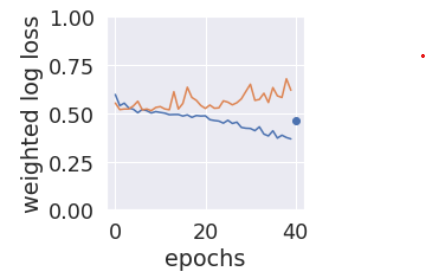

x = 400 3D images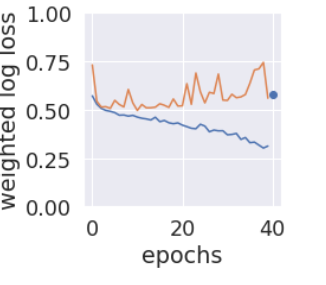

x = 500 3D images
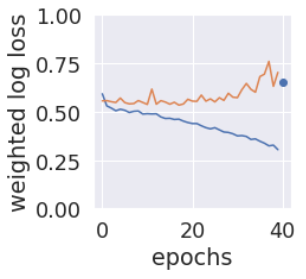

# x = 300 images & 10 epochs work best for unoptimized 3D CNN model

(32, 128, 128)


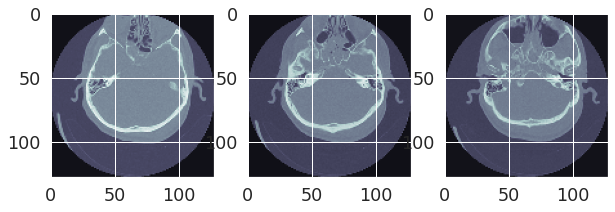

In [24]:

fig, ax = plt.subplots(1,3, figsize=(10,10))
print(np.array(X[1]).shape)
ax[0].imshow(X[13][10], cmap=plt.cm.bone)
ax[1].imshow(X[13][20], cmap=plt.cm.bone)
ax[2].imshow(X[13][30], cmap=plt.cm.bone)

plt.show()

In [25]:
 
def get_test_images_3D( img_size = (128,128)):
    
    path = '../input/rsna-2022-cervical-spine-fracture-detection/test_images'
    test_images = []
    test_ids = []
     
    
    ids = os.listdir('../input/rsna-2022-cervical-spine-fracture-detection/test_images')
    print("test images")
    print(ids)
    for id_ in ids: 
        # label C1-C7 fracture or not, print(labels)
        # file names of that id_
        id_files = os.listdir(path + '/' + id_)
         
            
        cuts = get_cut(id_files,32)  # index of 32 cuts
       
            
        cas = []
        # read each of the dcm files
        
        for i in range(32):
            try:
                image = pydicom.dcmread(path + '/' + id_ + '/' +str(cuts[i])+'.dcm').pixel_array
            except:
                print('error')
                # resize image
            image = np.array(cv2.resize(image, dsize=img_size))
            # rescale image 
            s, m=norm(image)
            image = (image - m)/s 
            # add image to train_image
            cas.append(image)
           # print(np.array(cas).shape)
            # add labels train_labels
        test_images.append(cas)    
        test_ids.append(id_)
    return test_images, test_ids
#try it out
#a=get_test_images_3D()
#(tf.convert_to_tensor(a[0],dtype=tf.float32)).shape

    

In [26]:
# test the function
test_images_3D, test_ids_3D = get_test_images_3D()
X_test=tf.convert_to_tensor(test_images_3D, dtype=tf.float32)

results_3D = model_3D.predict(X_test)
 
 

test images
['1.2.826.0.1.3680043.22327', '1.2.826.0.1.3680043.25399', '1.2.826.0.1.3680043.5876']


#### Prepare the submission file

In [27]:
results_df_3D = pd.DataFrame(data=results_3D, columns=cols)
results_df_3D.insert(0, 'patient_id', np.array(test_ids_3D))
results_df_3D = results_df_3D.melt(id_vars='patient_id', value_vars=cols, var_name='bone', value_name='fractured')
results_df_3D.insert(0, 'row_id', results_df_3D.patient_id + '_' + results_df_3D.bone)
results_df_3D.drop(['patient_id', 'bone'], axis=1, inplace=True)
results_df_3D = pd.DataFrame(results_df_3D.groupby(['row_id']).max().reset_index())
results_df_3D.head(30)

,row_id,fractured
0,1.2.826.0.1.3680043.22327_C1,0.114488
1,1.2.826.0.1.3680043.22327_C2,0.202111
2,1.2.826.0.1.3680043.22327_C3,0.042391
3,1.2.826.0.1.3680043.22327_C4,0.179197
4,1.2.826.0.1.3680043.22327_C5,0.072906
5,1.2.826.0.1.3680043.22327_C6,0.136019
6,1.2.826.0.1.3680043.22327_C7,0.306971
7,1.2.826.0.1.3680043.22327_patient_overall,0.650540
8,1.2.826.0.1.3680043.25399_C1,0.053318
9,1.2.826.0.1.3680043.25399_C2,0.112412


In [28]:
results_df_3D.to_csv('submission.csv', index=False)

# For fun, lets see if we rotate all image cuts of a patient by some certain degree, will the loss improve?

Plot all 32 images for a single patient

tf.Tensor(1.1318974, shape=(), dtype=float32)
(1, 32, 128, 128)


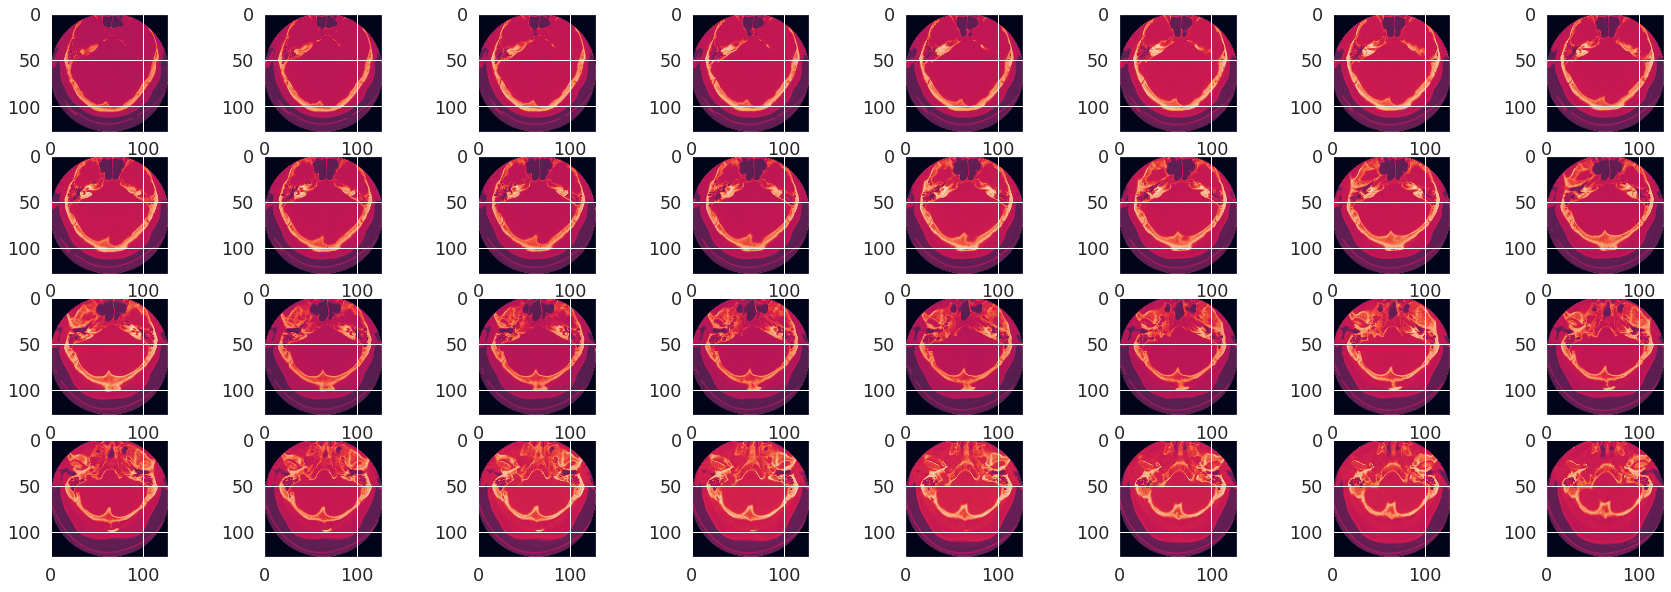

In [29]:
val3D_prediction=model_3D.predict(val3D_X)
val_3D_loss = tf.reduce_mean(CustomMSE(val3D_Y,val3D_prediction),keepdims=False)
print(val_3D_loss)
print(val3D_X.shape)
def plot_32(all_arr,len_dcms):
    ndcms=32
    fig, ax= plt.subplots(4,int(ndcms/4),figsize=(30,10))
    for i in range(ndcms):
        ax[int(i/int(ndcms/4))][i%int(ndcms/4)].imshow(all_arr[int(i*len_dcms/32)])
    plt.show()
    return

plot_32(val3D_X[0],32)

In [30]:
def rotate(image,angle):  #take a 2D numpy array image and rotate by angle
    (h, w) = image.shape[:2]
    center = (w / 2, h / 2)
    scale = 1

    M = cv2.getRotationMatrix2D(center, angle, scale)
    rotated = cv2.warpAffine(image, M, (w, h))
    return rotated

def rotate_3D(image_3D,angle): #take a 3D numpy array image_set and rotate by angle
    num = image_3D.shape[0]
    rotated=[]
    for i in range(num):
        rotated.append(rotate(image_3D[i],angle))
    return rotated

In [31]:
twist_X=[]   #3D image_set of single patient, each rotated by an angle ang
twist_Y=[]
for ang in range(-180,180,3): 
    image=np.array(val3D_X[0])
    rotated = rotate_3D(image,ang)
    twist_X.append(rotated)
    twist_Y.append(val3D_Y[0])   #ground truth does not change(not angle dependent)
print(np.array(twist_X).shape,np.array(twist_Y).shape)
twisttf_X=tf.convert_to_tensor(twist_X, dtype=tf.float32)
twisttf_Y=tf.convert_to_tensor(twist_Y, dtype=tf.float32)

(120, 32, 128, 128) (120, 8)


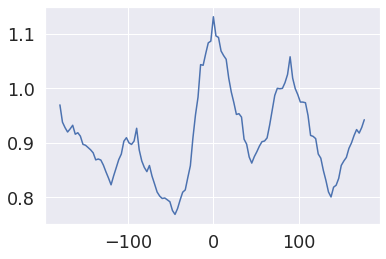

In [32]:
twisttf_prediction=model_3D.predict(twisttf_X)
twist_loss = (CustomMSE(twisttf_Y,twisttf_prediction))
#print(twist_loss)
 
plt.plot(range(-180,180,3),twist_loss)
 

# It is a BIG IMPROVEMENT!!! Lets' try 3D CNN for self-supervised rotated images perhaps?